In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import numpy as np
import pandas as pd
import datetime

np.set_printoptions(suppress=True)

In [2]:
from stocks import Stocks
from agents.agent import Agent
from utils import *
from visualizations import *

Using TensorFlow backend.


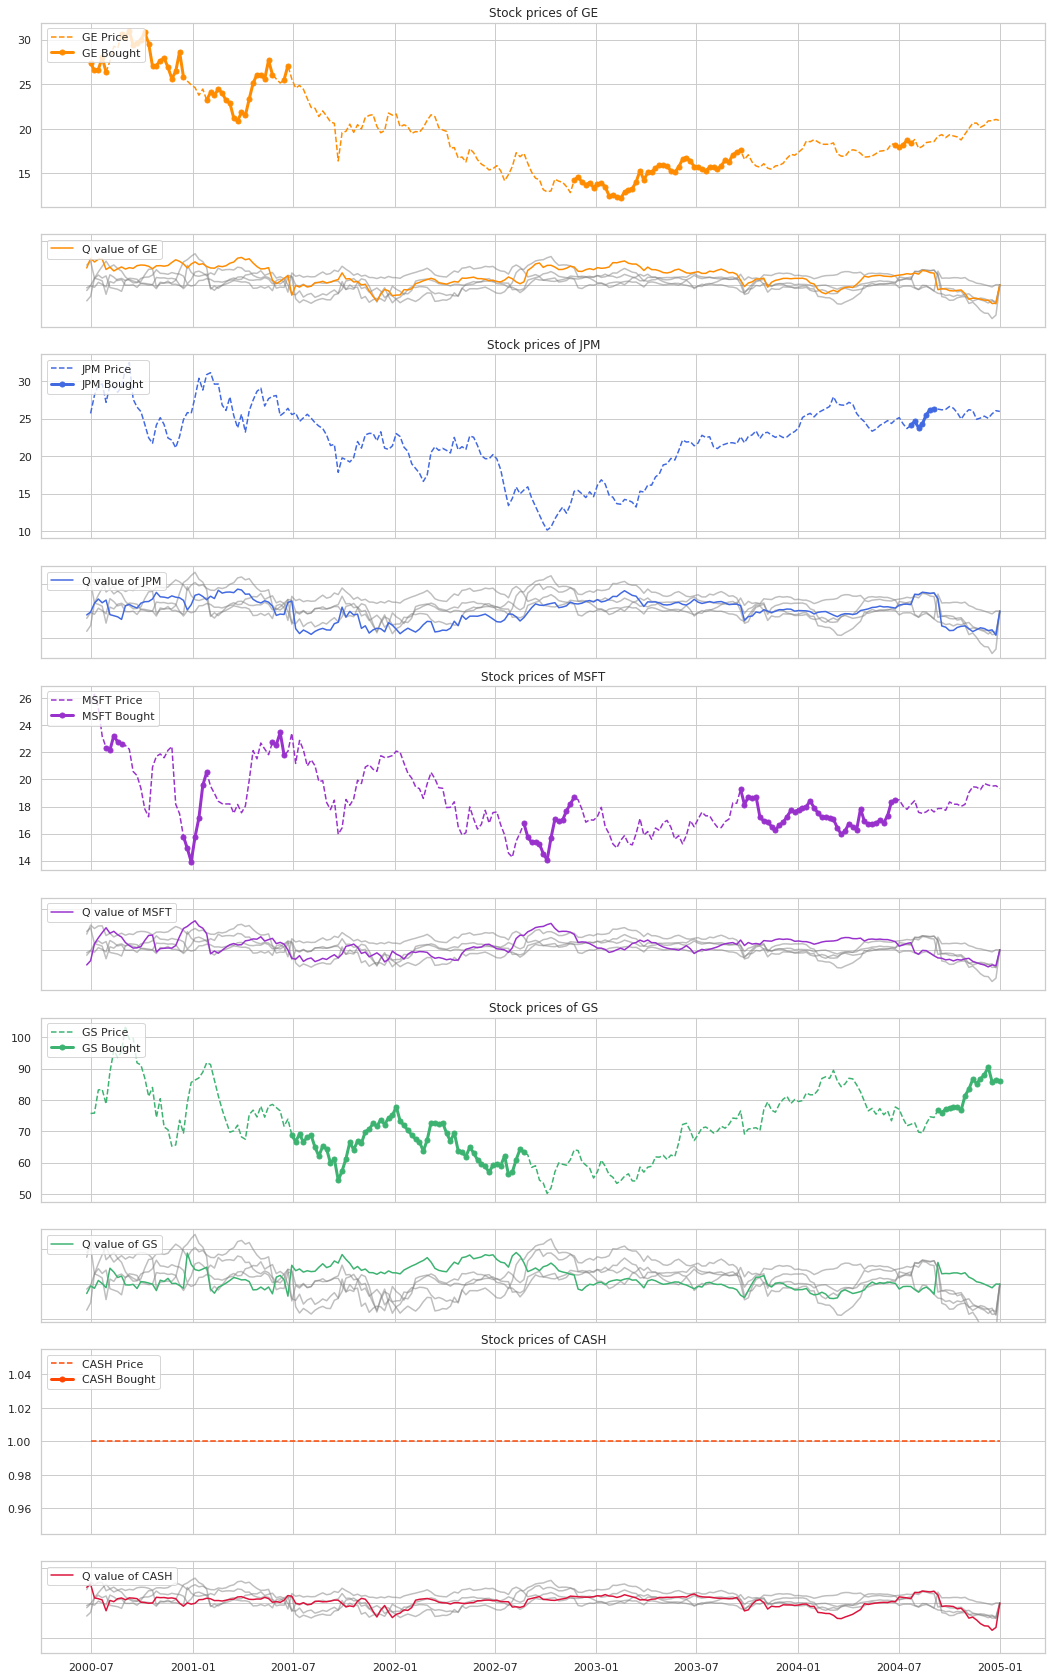

In [18]:
def plot_stocks(episode, mode):
    positions, rewards, returns, q_values = Agent.load_logs(episode, mode)

    dates = positions[np.sum(positions, 1) != 0].index
    tickers = positions.columns[:-1]

    start = dates[0].strftime("%Y-%m-%d")
    end = dates[-1].strftime("%Y-%m-%d")

    # Get the baseline stocks
    baseline = Stocks(tickers, start=start, end=end)

    stocks = positions.columns

    colors = ['darkorange', 'royalblue', 'darkorchid', 'mediumseagreen', 'orangered']

    positions[positions == 0] = np.nan
    positions = positions.bfill(limit=1)
    held = (baseline.prices * positions)

    fig, axis = plt.subplots(len(stocks)*2, 1, 
                             figsize=(18, len(stocks)*6), 
                             gridspec_kw={'height_ratios': [*[2,1] * len(stocks)]},
                             sharex=True)

    for index, stock in enumerate(stocks):
        stock_plot = axis[index*2]
        value_plot = axis[index*2+1]

        # Color of the stock
        color = colors[index]

        if stock == 'CASH':
            color = 'crimson'

        # Add the cash stock
        baseline.prices['CASH'] = 1
        stock_plot.plot(baseline.prices[stock], color=colors[index], linestyle='dashed')
        stock_plot.plot(held[stock], linewidth=3, color=colors[index], marker='o', markersize=5)
        stock_plot.legend([f'{stock} Price', f'{stock} Bought'], loc='upper left')
        stock_plot.set_title(f'Stock prices of {stock}')

        # background Q values
        for q_value_index, q_value_stock in enumerate(stocks):
            if q_value_stock is not stock:
                value_plot.plot(q_values[q_value_stock], 
                                color='gray',
                                alpha=0.5)

        # Plot actual Q value
        value_plot.plot(q_values[stock], 
                        color=color,
                        label=f'Q value of {stock}')

        min_q = q_values[stock].min()
        max_q = q_values[stock].max()
        q_margin = (max_q - min_q) / 2

        value_plot.legend(loc='upper left')
        value_plot.set_ylim(min_q - q_margin, max_q + q_margin)
        plt.setp(value_plot.get_yticklabels(), visible=False)

EPISODE = 315
        
plot_stocks(EPISODE, 'training')

## Testing plots

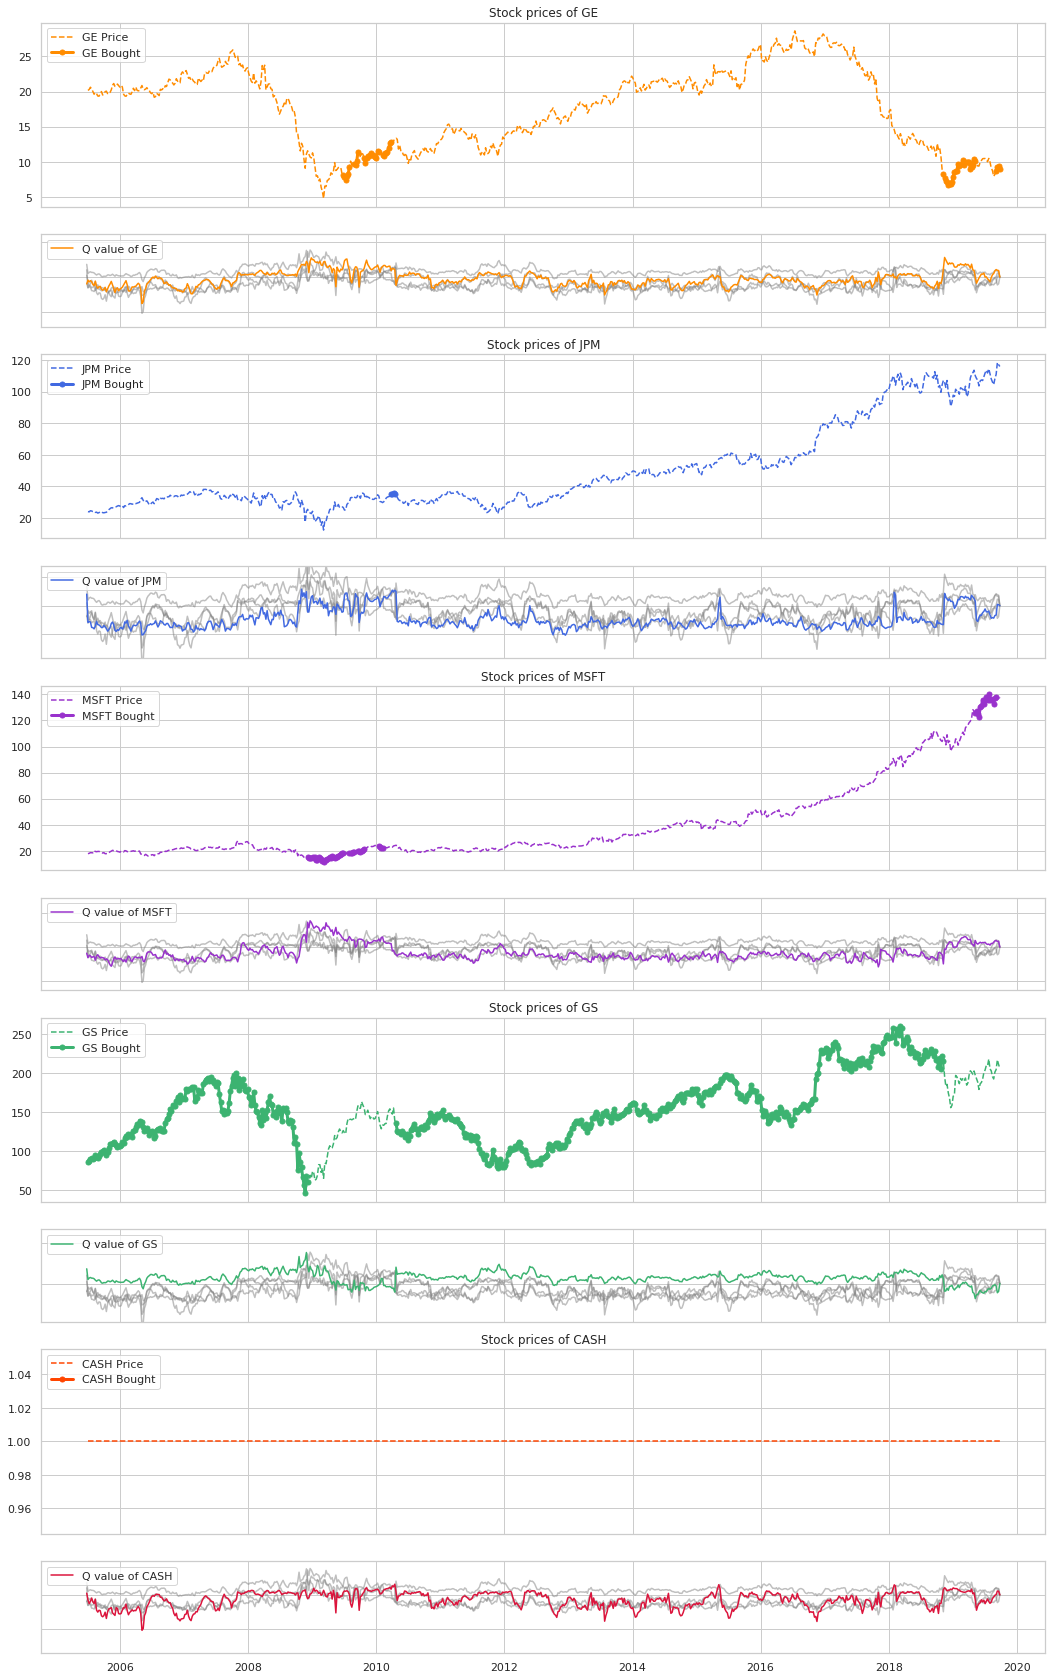

In [19]:
plot_stocks(EPISODE, 'testing')

In [20]:
def plot_results(episode, mode):
    # Open the log file
    positions, rewards, returns, q_values = Agent.load_logs(episode, mode)
    
    dates = positions[np.sum(positions, 1) != 0].index
    tickers = positions.columns[:-1]
    
    start = dates[0].strftime("%Y-%m-%d")
    end = dates[-1].strftime("%Y-%m-%d")
    
    # Get the baseline stocks
    baseline = Stocks([*tickers, 'SPY'], start=start, end=end)
    
    # Plot cumulative rewards
    plot_cumulative_returns(pd.concat([simple_returns(baseline.prices), returns], 1))
    
    # Plot q values
    plot(q_values, title='Q values', ylabel='Q value')
    
    # Drawdown plot
    plot_drawdown(returns)
    
    # Drawdown of the S&P index
    plot_drawdown(simple_returns(baseline.prices['SPY']), title='Drawdown of S&P 500')
    
    # Position percentages
#     plot_positions(positions)
    
    return show_sharpe_ratio(pd.concat([simple_returns(baseline.prices), returns], 1))

,Sharpe ratio
GE,-0.122332
JPM,1.82052
MSFT,2.67872
GS,1.31298
SPY,2.17537
returns,1.40516


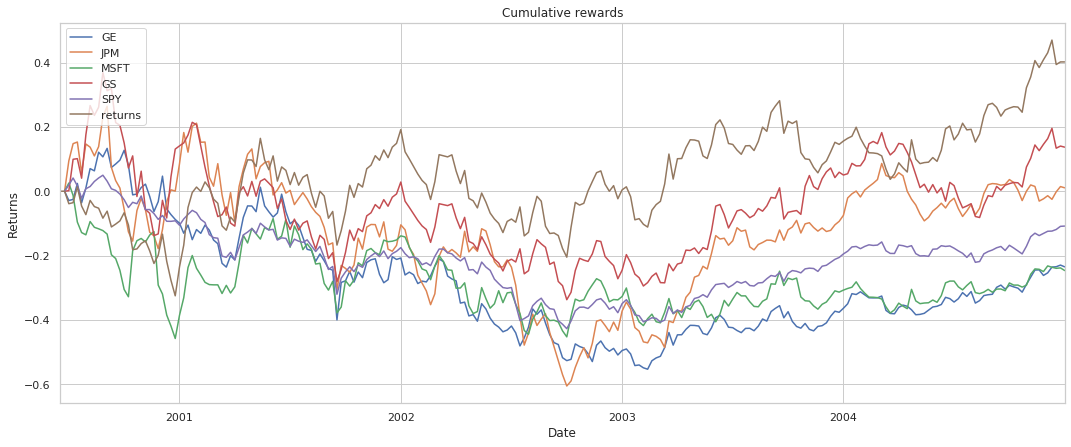

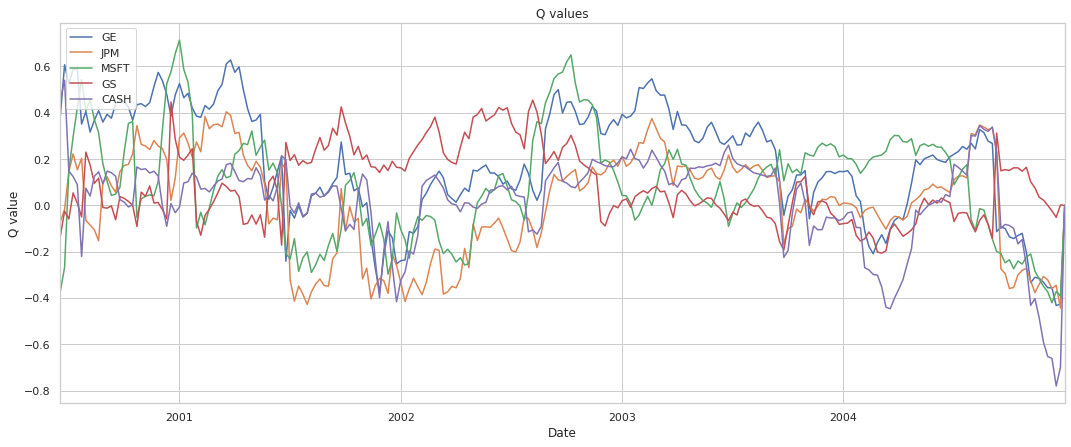

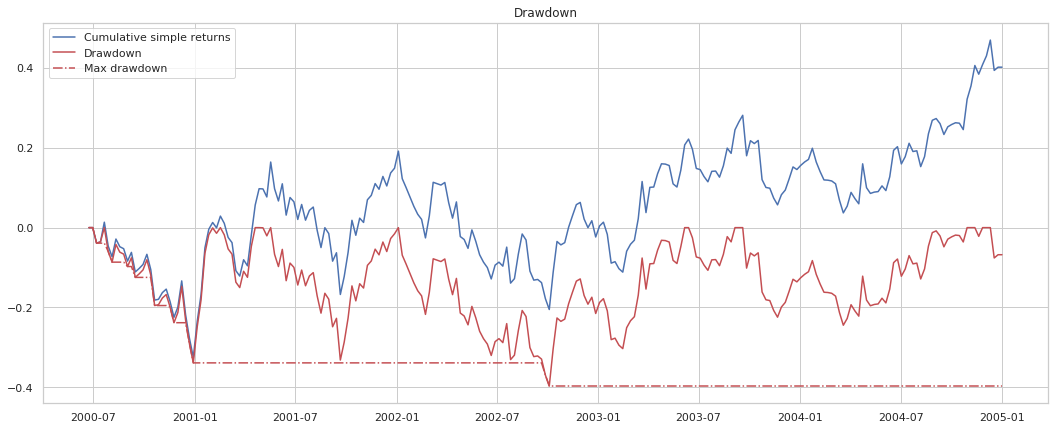

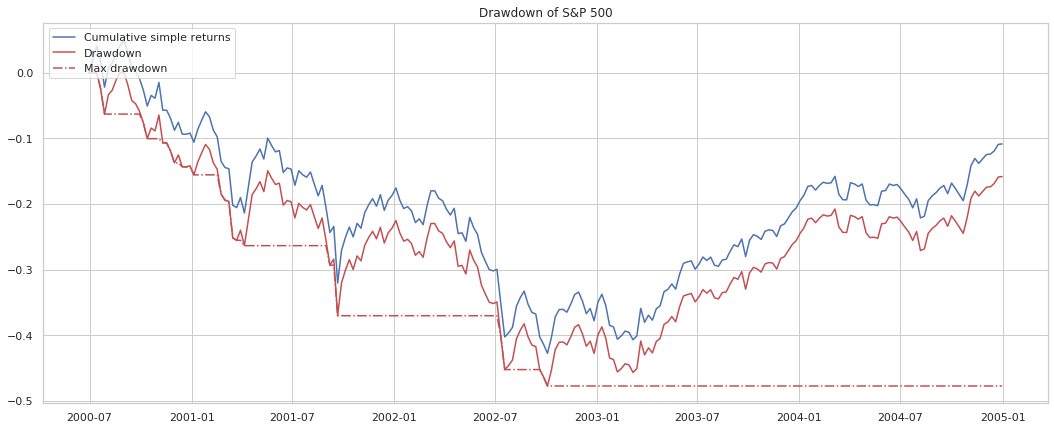

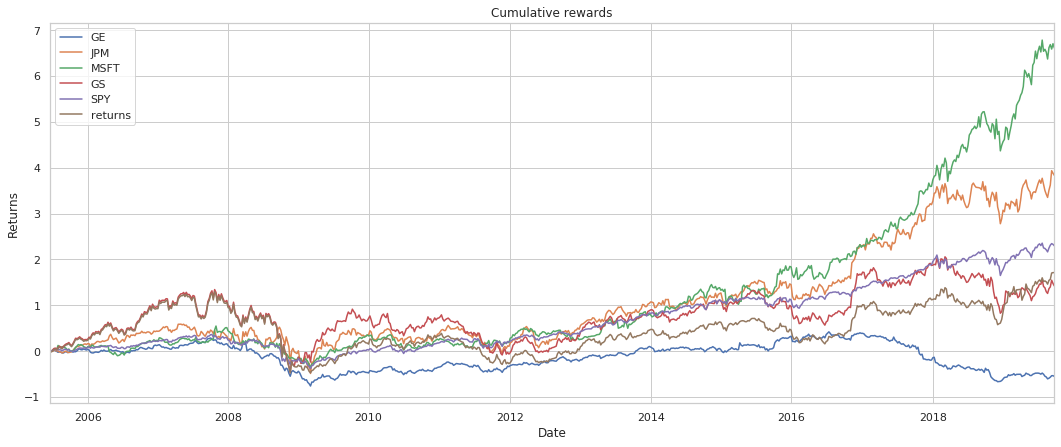

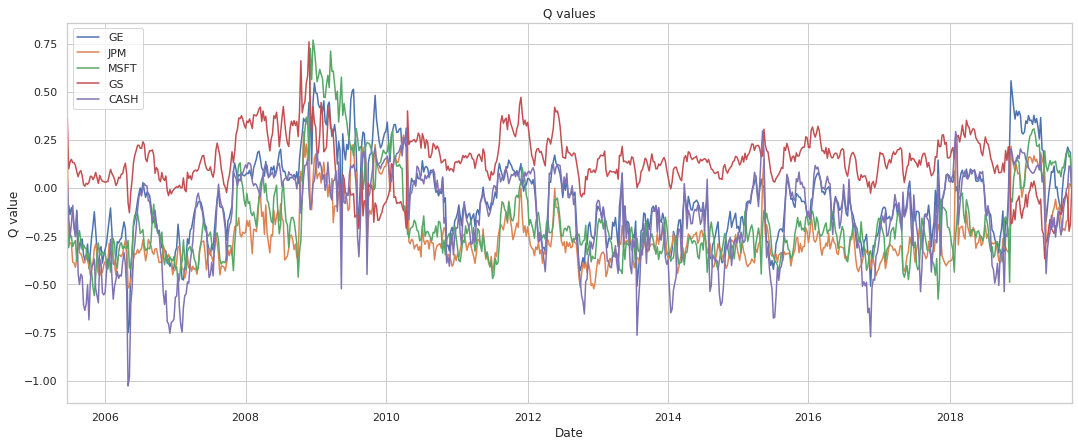

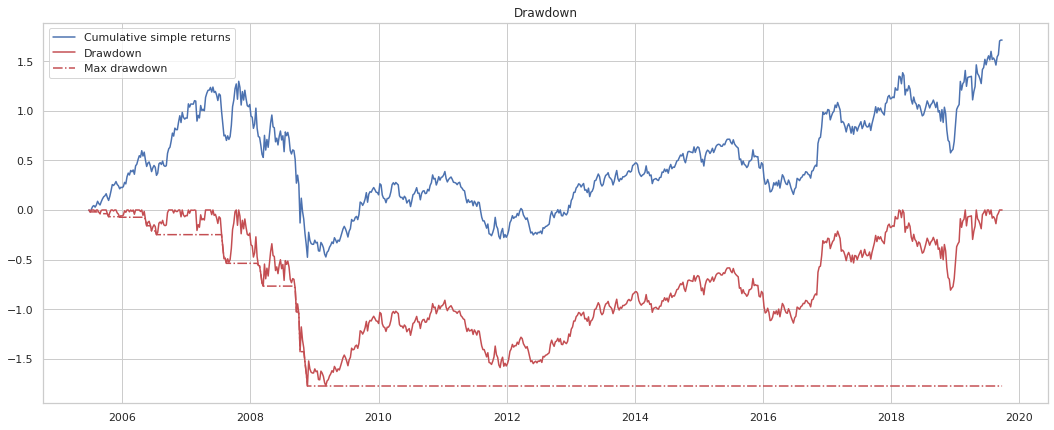

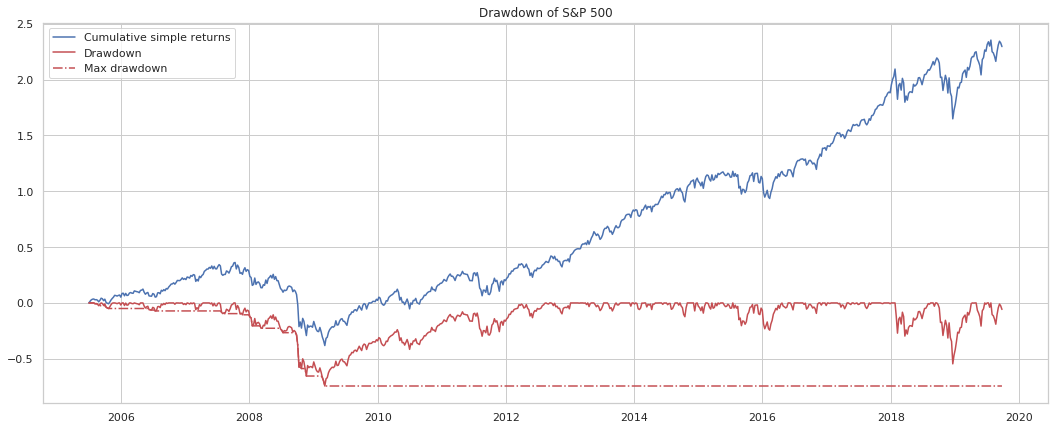

In [21]:
plot_results(EPISODE, 'training')
plot_results(EPISODE, 'testing')